In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import time

sys.path.append('./mrcnn')

import utils
import model as modellib
import visualize
import config

import dot_dataset
import cam

classnames = ['BG', 'dot']

Using TensorFlow backend.


In [2]:
import cv2

In [3]:

import serial
import time

ard = serial.Serial('COM13', 9600, timeout=5)

def goto(x, y):
    message = str(x)+','+str(y)
    message = message.encode()
    ard.write(message)
    print(ard.readline())
    time.sleep(.5)
    


In [4]:
def erase():
    goto('z', .2)
    goto(-.25, -.25)
    goto(0, .5)
    goto(.25, -.5)
    goto(0, .5)
    goto(.25, -.5)
    goto(0, .5)
    goto(-.25, -.25)
    goto('z', -.2)
    
def get_calibration_dots(numberx, numbery, spacingx, spacingy, spacingz):
    points = []
    direction = 1
    points.append(['z', spacingz])
    points.append(['z', -spacingz])
    for x in range(numberx):
        for y in range(numbery):
            points.append([0, direction*spacingy])
            points.append(['z', spacingz])
            points.append(['z', -spacingz])
        points.append([spacingx, 0])
        points.append(['z', spacingz])
        points.append(['z', -spacingz])
        direction = direction * -1
    return points

def draw_calibration_dots(ard, points):
    for x,y in points:
        goto(x,y)

In [ ]:
points = get_calibration_dots(5,5,2,2,.2)
draw_calibration_dots(ard, points)

In [5]:
def get_inference_model(model_name="dotmodel_1class80.h5"):
    ''' Loads weights and returns an inference model '''

    inference_config = dot_dataset.InferenceConfig()
    model = modellib.MaskRCNN(mode="inference", 
                              config=inference_config,
                              model_dir='./logs')
    print("Loading weights from ", model_name)
    model.load_weights(model_name, by_name=True)
    return model

model = get_inference_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loading weights from  dotmodel_1class80.h5


In [6]:
def get_mark_center(rois):
    centroids = []
    for dot in rois:
        centroids.append(np.stack([
            dot[1] + ((dot[3] - dot[1]) / 2.0),
            dot[0] + ((dot[2] - dot[0]) / 2.0),
        ], -1))
    return centroids

def find_dots(model, img):
    results = model.detect([img], verbose=1)
    r = results[0]
    if len(r['rois']) > 0:
        centroids = get_mark_center(r['rois'])
        return centroids, r

In [7]:
# Open Webcam
video_capture = cv2.VideoCapture(1)
if not video_capture.isOpened():
    raise Exception("Could not open video device")

def get_cam_frame(cam):
    ret, frame = cam.read()
    return frame

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  164.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   49.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


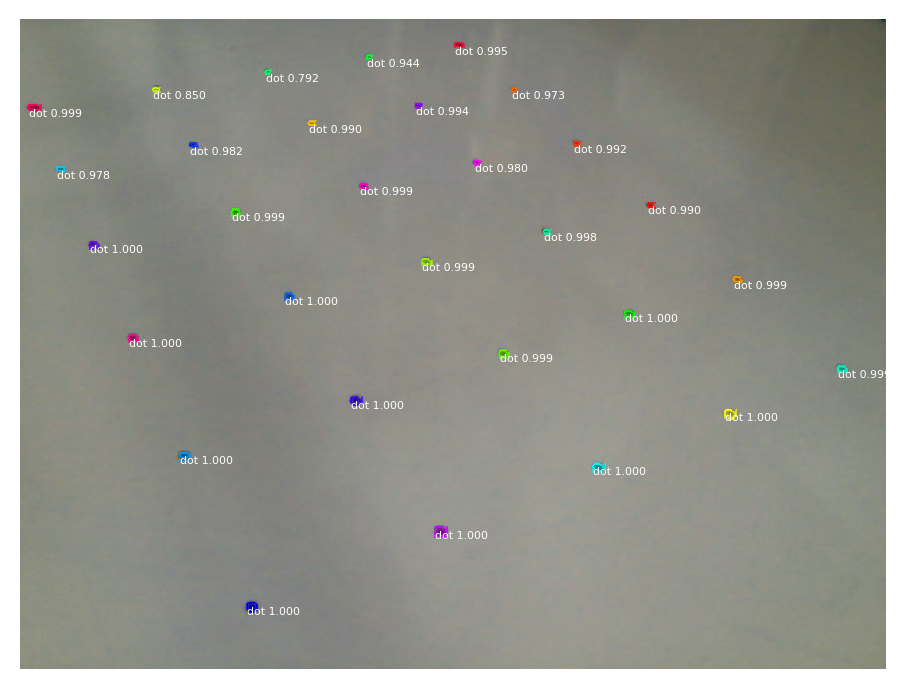

In [12]:
img = get_cam_frame(video_capture)
results = model.detect([img], verbose=1)

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            classnames, r['scores'])

In [31]:
centers = get_mark_center(r['rois'])
centers

[array([427.5, 331. ]),
 array([310.5, 378.5]),
 array([525. , 291.5]),
 array([248., 282.]),
 array([450.5, 217.5]),
 array([198.5, 204.5]),
 array([ 83.5, 235.5]),
 array([171. , 434.5]),
 array([121.5, 322.5]),
 array([ 54.5, 166.5]),
 array([159. , 142.5]),
 array([357.5, 247. ]),
 array([300.5, 179. ]),
 array([607.5, 258. ]),
 array([254., 123.]),
 array([530., 192.]),
 array([10.5, 65. ]),
 array([389.5, 156.5]),
 array([324.5,  18.5]),
 array([294.5,  63.5]),
 array([411.5,  91.5]),
 array([466.5, 137. ]),
 array([215.5,  76.5]),
 array([128. ,  92.5]),
 array([338. , 105.5]),
 array([ 30. , 110.5]),
 array([365. ,  51.5]),
 array([258. ,  27.5]),
 array([100.5,  51.5]),
 array([183. ,  38.5])]

In [34]:
src = []
for x,y in centers:
    src.append([x,y])

cncpoints = []
for i in range(6):
    for j in range(5):
        cncpoints.append([j*2,i*2])
cncpoints
# calculate matrix H
h, status = cv2.findHomography(np.float32(src), np.float32(cncpoints))


array([[ 0.02509919, -0.11621656,  4.10125431],
       [ 0.02808894, -0.13814814,  5.40939465],
       [ 0.00659704, -0.03020044,  1.        ]])

In [8]:
h = [[ 0.02509919, -0.11621656,  4.10125431],
       [ 0.02808894, -0.13814814,  5.40939465],
       [ 0.00659704, -0.03020044,  1.        ]]

In [35]:
a = np.array([[200, 375]], dtype='float32')
a = np.array([a])
 
# finally, get the mapping
pointsOut = cv2.perspectiveTransform(a, h)
pointsOut

array([[[3.8264544, 4.5280333]]], dtype=float32)

In [16]:
x = []
y = []
for i in centers:
    x.append(i[0])
    y.append(i[1])

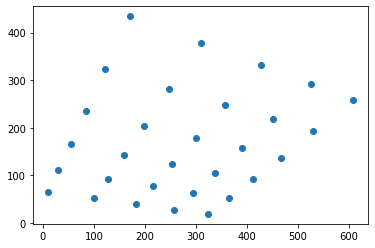

In [23]:
import matplotlib.pyplot as plt
plt.scatter(x,y)

In [20]:
# find the corners
# we know that the corner points will be closest to the
# edge of the frame
smallx = [600, 0]
smally = [600, 0]
largex = [0, 0]
largey = [0, 0]
for i, p1 in enumerate(centers):
    if p1[0] < smallx[0]:
        smallx = [p1[0], i] 
    if p1[1] < smally[0]:
        smally = [p1[1], i]
    if p1[0] > largex[0]:
        largex = [p1[0], i]
    if p1[1] > largey[0]:
        largey = [p1[0], i]
print(smallx)
print(smally)
print(largex)
print(largey)


[10.5, 16]
[18.5, 18]
[607.5, 13]
[357.5, 11]


In [32]:
import numpy as np
print(centers)
for i, _ in enumerate(centers):
    for j, _ in enumerate(centers):
        if centers[i][0] < centers[j][0]:
            centers[i], centers[j] = centers[j], centers[i] 
centers

[array([482., 258.]), array([ 34., 144.]), array([564.5, 342.5]), array([413. , 190.5]), array([13.5, 92. ]), array([464., 390.]), array([310.,  88.]), array([171., 179.]), array([386. , 293.5]), array([322. , 216.5]), array([134.5, 385. ]), array([227.5, 104. ]), array([342., 448.]), array([270., 155.]), array([271. , 335.5]), array([270., 336.]), array([136., 122.]), array([ 92.5, 285. ]), array([215., 248.])]


[array([13.5, 92. ]),
 array([ 34., 144.]),
 array([ 92.5, 285. ]),
 array([134.5, 385. ]),
 array([136., 122.]),
 array([171., 179.]),
 array([215., 248.]),
 array([227.5, 104. ]),
 array([270., 336.]),
 array([270., 155.]),
 array([271. , 335.5]),
 array([310.,  88.]),
 array([322. , 216.5]),
 array([342., 448.]),
 array([386. , 293.5]),
 array([413. , 190.5]),
 array([464., 390.]),
 array([482., 258.]),
 array([564.5, 342.5])]

In [22]:
import cv2
import numpy as np
# provide points from image 1
pts_src = np.array([
    [13.5, 92. ],
    [ 34., 144.],
    [ 92.5, 285. ],
    [134.5, 385. ],
    [136., 122.],
    [171., 179.],
    [215., 248.],
    [227.5, 104. ],
    [270., 336.],
    [270., 155.],
    [310.,  88.],
    [322. , 216.5],
    [342., 448.],
    [386. , 293.5],
    [413. , 190.5],
    [464., 390.],
    [482., 258.],
    [564.5, 342.5]
])
# corresponding points from image 2 (i.e. (154, 174) matches (212, 80))
pts_dst = np.array([
    [0,10],
    [0,8],
    [0,4],
    [0,2],
    [2,8],
    [2,6],
    [2,4],
    [4,8],
    [2,2],
    [4,6],
    [6,8],
    [4,4],
    [2,0],
    [4,2],
    [6,4],
    [4,0],
    [6,2],
    [6,0]
])

 
# calculate matrix H
h, status = cv2.findHomography(pts_src, pts_dst)
print (h)
# provide a point you wish to map from image 1 to image 2
a = np.array([[154, 174]], dtype='float32')
a = np.array([a])
 
# finally, get the mapping
pointsOut = cv2.perspectiveTransform(a, h)

[[ 2.25710271e-02 -9.50817619e-03  6.05813403e-01]
 [-1.12787035e-02 -2.40186381e-02  1.46204801e+01]
 [-2.99703659e-04  2.50587893e-03  1.00000000e+00]]


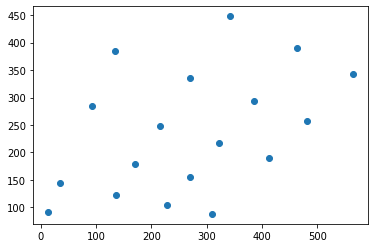

In [20]:
import matplotlib.pyplot as plt
x = []
y = []
for i in pts_src:
    x.append(i[0])
    y.append(i[1])
plt.scatter(x,y)

[-86.42433714816836, -141.70765814495917, -293.067240078565, -400.6697804570089, -173.6550992617015, -240.51854727741454, -322.2743001385408, -203.8166419935816, -425.9845356715714, -269.233937586588, -231.21023553303058, -348.49449991933096, -558.9793808954286, -447.1784560107327, -371.47783942093554, -569.7499074759311, -464.4345541763852, -578.8637007961702]


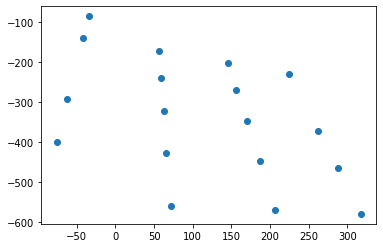

In [33]:
import numpy as np

a = np.deg2rad(150)
R = [[np.cos(a), -np.sin(a)],
     [np.sin(a),  np.cos(a)]]
newx, newy = [], []
for i in pts_src:
    x, y = np.matmul(R, [i[1],i[0]])
    newx.append(x)
    newy.append(-y)
print (newx)
plt.scatter(newy, newx)

In [9]:
current_point = [0,0]

Processing 1 images
image                    shape: (480, 640, 3)         min:   21.00000  max:  134.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   30.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


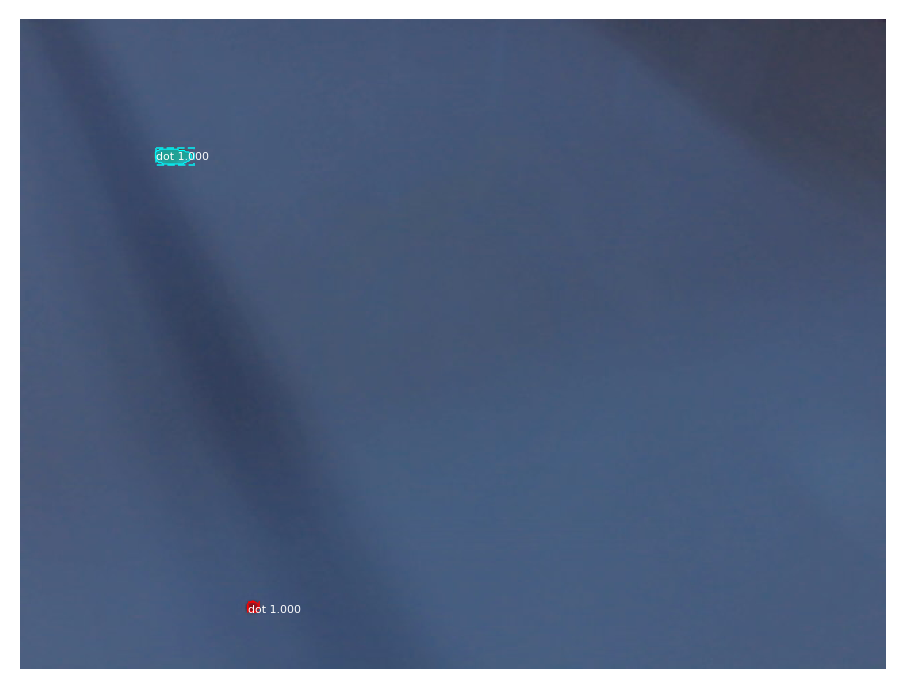

[array([114., 101.]), array([172., 434.])]

In [10]:
video_capture = cv2.VideoCapture(1)
if not video_capture.isOpened():
    raise Exception("Could not open video device")
img = get_cam_frame(video_capture)
results = model.detect([img], verbose=1)

r = results[0]
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                            classnames, r['scores'])
centers = get_mark_center(r['rois'])
centers

In [12]:
b = np.array([[centers[0][0], centers[0][1] ]], dtype='float32')
b = np.array([b])
pointsOut = cv2.perspectiveTransform(b, np.float32(h))
print (pointsOut)
print (pointsOut[0][0][0]-current_point[0], pointsOut[0][0][1]-current_point[1])

goto(pointsOut[0][0][0]-current_point[0], pointsOut[0][0][1]-current_point[1])
current_point = [pointsOut[0][0][0], pointsOut[0][0][1]]

[[[3.6784604 4.1145453]]]
3.6784603595733643 4.1145453453063965
b''


In [24]:
# time.sleep(1)
erase()

b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'


In [ ]:
center = [8,0]
goto(8,0)
while True:
    img = get_cam_frame(video_capture)
    results = model.detect([img], verbose=1)
    r = results[0]
    centers = get_mark_center(r['rois'])
    try:
        b = np.array([[centers[0][0], centers[0][1] ]], dtype='float32')
        b = np.array([b])
        pointsOut = cv2.perspectiveTransform(b, h)
        print (pointsOut)
        print (pointsOut[0][0][0]-current_point[0], pointsOut[0][0][1]-current_point[1])

        goto(pointsOut[0][0][0]-current_point[0], pointsOut[0][0][1]-current_point[1])
        current_point = [pointsOut[0][0][0], pointsOut[0][0][1]]
        
        erase()
    except:
        print ('no dot')

b'1\r\n'
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[[2.4743161 4.7892094]]]
-0.41856527 -0.22716331
b''
b''
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
b'1\r\n'
Processing 1 images
image                    shape: (480, 640, 3)         min:    3.00000  max:  242.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  117.30000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[[[2.3659728 2.3544412]]]
-0.10834336 -2.4347682
b'1\r\n'